# CSCE 823 HW3 Example solution

Original author: Luis Rosario

Modified by Borghetti (20210728) to make compatible with Tensorflow 2.x

Note that some Epoch quantities have been lowered to allow the code to run quickly... to actually train a model, alter this line in block 13


```EPOCHS_TO_RUN = 2   #set to 2 for testing code;  set to 200 for real solution```


CSCE 823 Assginment 3
---

In [1]:
import numpy as np
import pandas as pd
import os, pickle, itertools, pylab, keras, warnings, h5py, time, datetime
from IPython.display import SVG, Image

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mptl

import tensorflow as tf
from tensorflow import keras as keras



from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, BatchNormalization, 
Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D, GlobalAveragePooling2D)
    
from tensorflow.keras.optimizers import Adam, SGD
#from tensorflow.keras.utils import np_utils, plot_model
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from keras import callbacks
from keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import confusion_matrix

# note - although not shown here you will need packages hdf5 and h5py installed in your environment

In [2]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Utilities

In [4]:
# ---------------- Utils -------------------------------

#load data
def load_cifar10_data():
    """Loads the cifar10 image set and generates train and test data
    note that y is converted to categorical (dummy variables)
    :return: x_train, y_train, x_test, y_test, num_classes
    """
    num_classes = 10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    return x_train, y_train, x_test, y_test, num_classes


def show_cifar10_images(imageset = range(0, 9)):
    """
    Displays some of the images in CIFAR10
    :param imageset: list of 9 image indexes to display
    :return:
    """
    # load data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    print('X_train shape ', X_train.shape)
    # create a grid of 3x3 images
    for i in imageset:
        plt.subplot(330 + 1 + i)
        X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        plt.imshow(X_train[i].reshape(32, 32, 3), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show(block=False)


def plot_confusion_matrix(cm, class_labels, title='Confusion matrix',
                          filename = 'Confusion_Matrix.png', cmap=plt.cm.Blues):
    """
    Plot a confusion matrix
    :param cm: a confusion matrix generated by sklearn.metrics.confusion_matrix
    :param class_labels: set of text labels
    :param title: title of figure
    :param cmap: color map for the confusion matrix
    :return:
    """
    class_count = len(class_labels)
    fig = plt.figure(title)
    fig.set_size_inches(10, 8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(class_count+1)
    tick_marks = np.arange(class_count)
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename, dpi=100)
    np.set_printoptions(precision=2)
    plt.show(block=False)


def save_CNN_model(model, save_dir=os.path.join(os.getcwd(), 'saved_models'),
                   model_file_name='keras_cifar10_trained_model.h5'):
    """
    Save model and current weights
    :param model: Keras model
    :param save_dir: path name to save directory
    :param model_file_name: filename for saved model
    :return: nothing
    """
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)
    

def load_CNN_model(save_dir, model_file_name):
    # Load model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_file_name)
    model = load_model(model_path)
    print('Loaded trained model from %s ' % model_path)
    return model


def get_random_eraser(p=0.5, w = 16, h = 16, v_l=0, v_h=255, pixel_level=False):
    '''
    Input:
    p: floating point representing the probablity of cutout
    w: the width of the desire cutout
    h: the height of the desire cutout
    v_l: the lower value of the pixel color pixel level cutouts
    v_h: the upper bound on the pixel color for pixel level cutouts
        https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

    '''

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand() #Random probability

        if p_1 > p:
            return input_img

        while True:
            left = np.random.randint(0, img_w) #Get the location of the cutout
            top = np.random.randint(0, img_h)


            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        image_CO = input_img.copy()
        image_CO[top:top + h, left:left + w, :] = c

        return image_CO

    return eraser

# Model Definitions Section
## Provided Models

# Step 1.
## Existing Architecture Documentation:
You have inherited 2 Keras CNN architectures (shallow, deep).  Your goal in this step is to document the models.  Examine the layers of each model in the code (using keras’s tools like .summary), and develop a diagram (e.g. using Powerpoint) of the layers like you’ve seen in class or on the internet.  Save the diagram as an image that can be imported/displayed in your notebook with a code cell near the model’s code.  In a markdown cell, describe the architectures and their parameterization.  How many parameters are there?  What other features are present in these models.  How do they differ?  What is your conjecture about their expected performance on the CIFAR10 dataset?


In [5]:
# ---------------- CNN Section -------------------------

def compile_shallow_CNN_model(input_shape, num_classes, batch_size=32):
    """Compiles a shallow CNN: conv - maxpool - conv - maxpool - dense - dense
    :param input_shape: tensor shape of the input
    (3 dim for 3 channel color images: colorChannel, height, width)
    :param num_classes: name of the h5 file containing the trained model params
    :param batch_size=32: size of the batches used for training
    :return: compiled model
    """
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])
    return model


def compile_deep_CNN_model(input_shape, num_classes, batch_size=32):
    """Compiles a simple deep CNN: with conv, maxpool, dropout
    :param input_shape: tensor shape of the input (not including observation count)
    (3 dim for 3 channel color images)
    :param num_classes: name of the h5 file containing the trained model params
    :param batch_size=32: size of the batches used for training
    :return: compiled model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    # compile the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

# Shallow CNN Architecture
#### The diagram below lays out the structure of the  shallow CNN. The CNN takes as inputs a tensor of shape (32,32,3) excluding the batch size. Because the Conv2D has 32 kernals of size (5,5) and a stride size of (1,1), the output is a (28,28,32).  The dimension shrinkage is due to the lack of padding. The Conv2D is followed by a Max_Pooling2D layer which further reduces the dimensions to (14,14,32). A Conv2D layer and a Max_Pooling2D layer is repeated once again until we arrive to a set of activations of dimensions (5,5,64). This 3D output is flatten in order to be fed to two Dense layers for classification. The last Dense layer contains 10 units and uses a Softmax activation function for 10-way classification. This shallow model has a total of 1,664,706 parameters as is shown in the model summary below.

#### Without running the model, it can be deduced that this model will overfit on the training data. We have 32 filters being appplied to a 32x32x3 input image and no dropout. This model will need to be regularized by some means. 

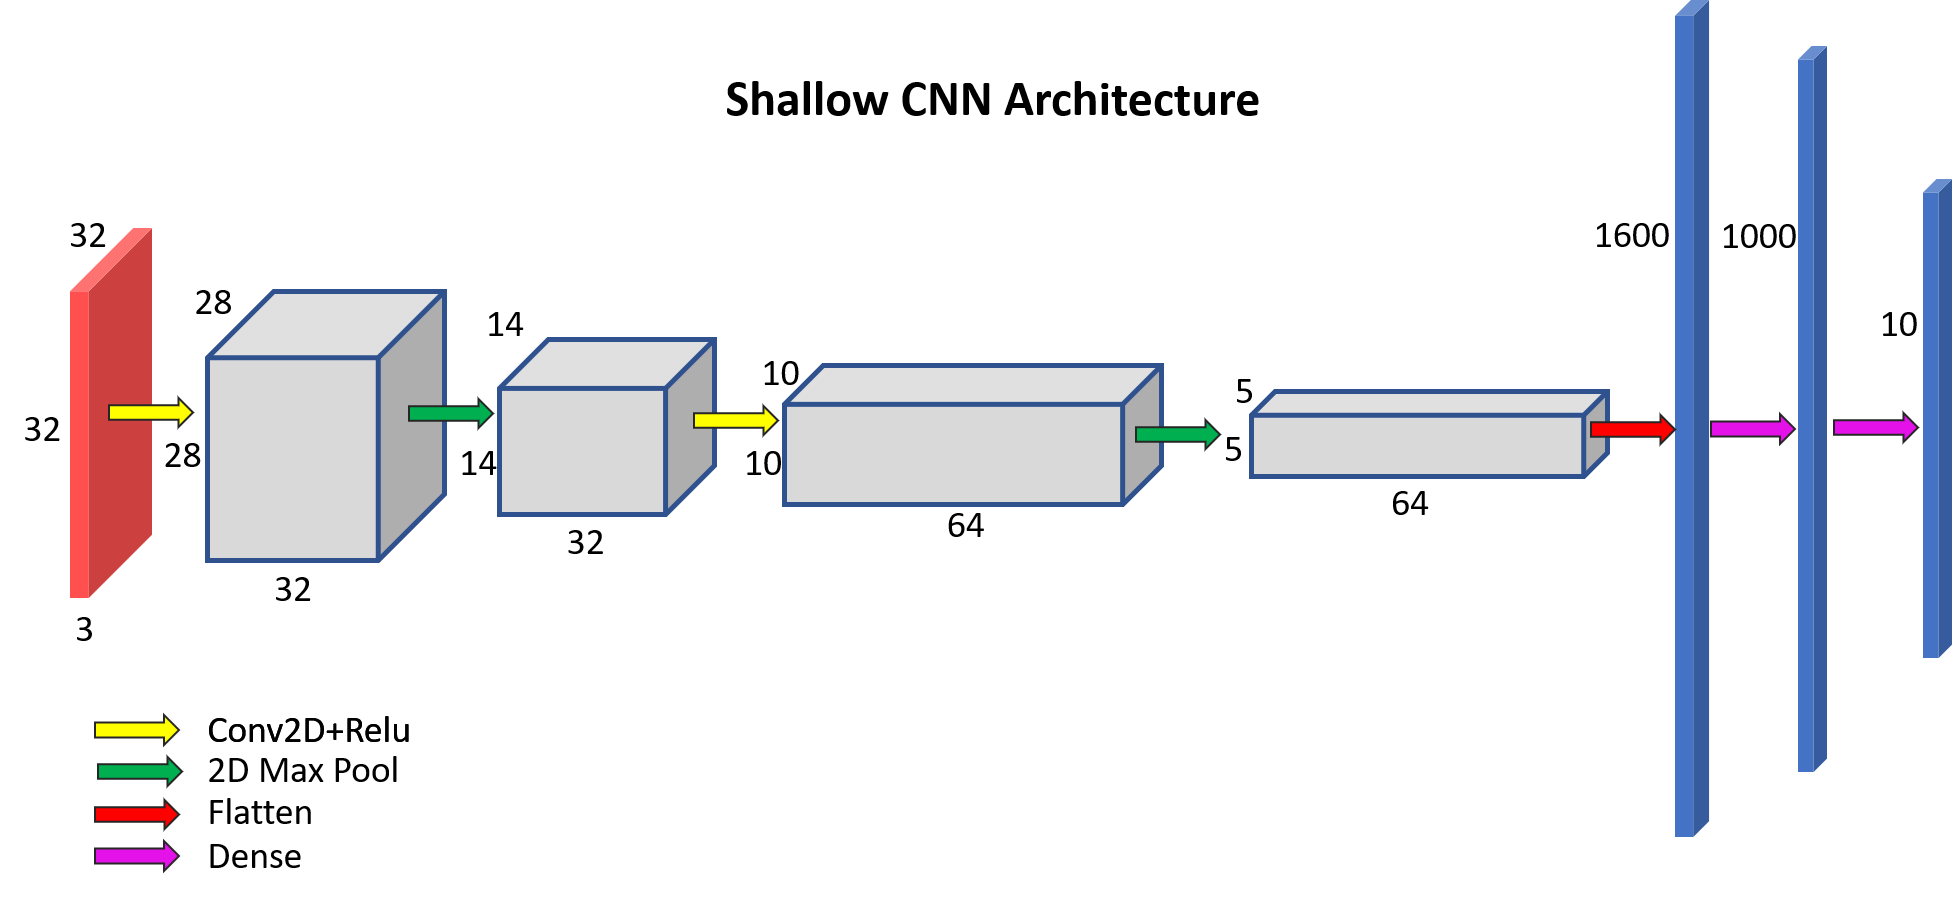

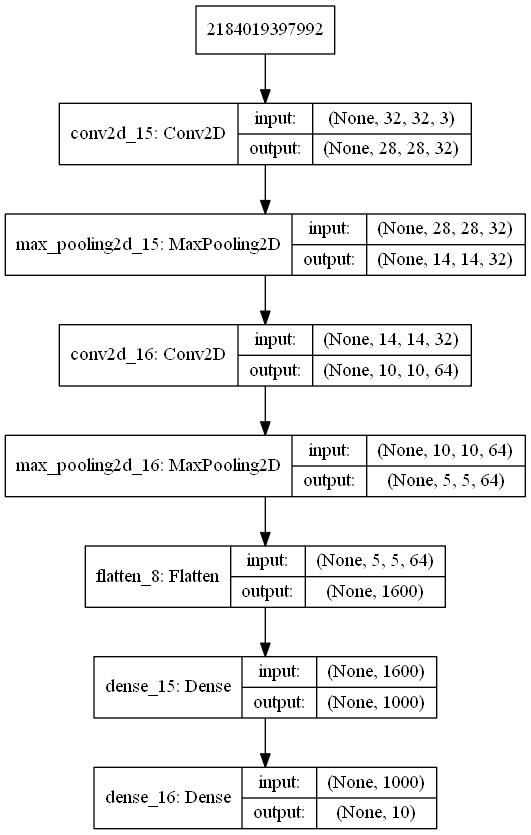


In [6]:
# ...... download/load data ......
x_train, y_train, x_test, y_test, num_classes = load_cifar10_data()
input_shape = x_train.shape[1:]
batch_size = 32

model = compile_shallow_CNN_model(input_shape, num_classes, batch_size)
# print(model.summary())
plot_model(model, show_shapes=True,to_file='shallow_model.png')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Deep CNN Architecture

#### The diagram below lays out the structure of the deep CNN. The CNN takes as inputs a tensor of shape (32,32,3) excluding the batch size. The first Conv2D has 32 kernals of size (3,3) and doesn't reduce the dimension of the resulting activation. This layer is followed by another Conv2D layer, a MaxPooling2D and a Dropout layer for regularization. The filters on these model are smaller than on the previous shallow model for this reason the output of the first Conv2D layer in this model has less training parameters. This model has a total of 1,250,858 trainable parameters. That is 25% less parameters than the shallow network which translates to less computations and faster convergence. I do not know if this model is deep enough to learn from the small amout of data that we have and if it will have the capacity needed.

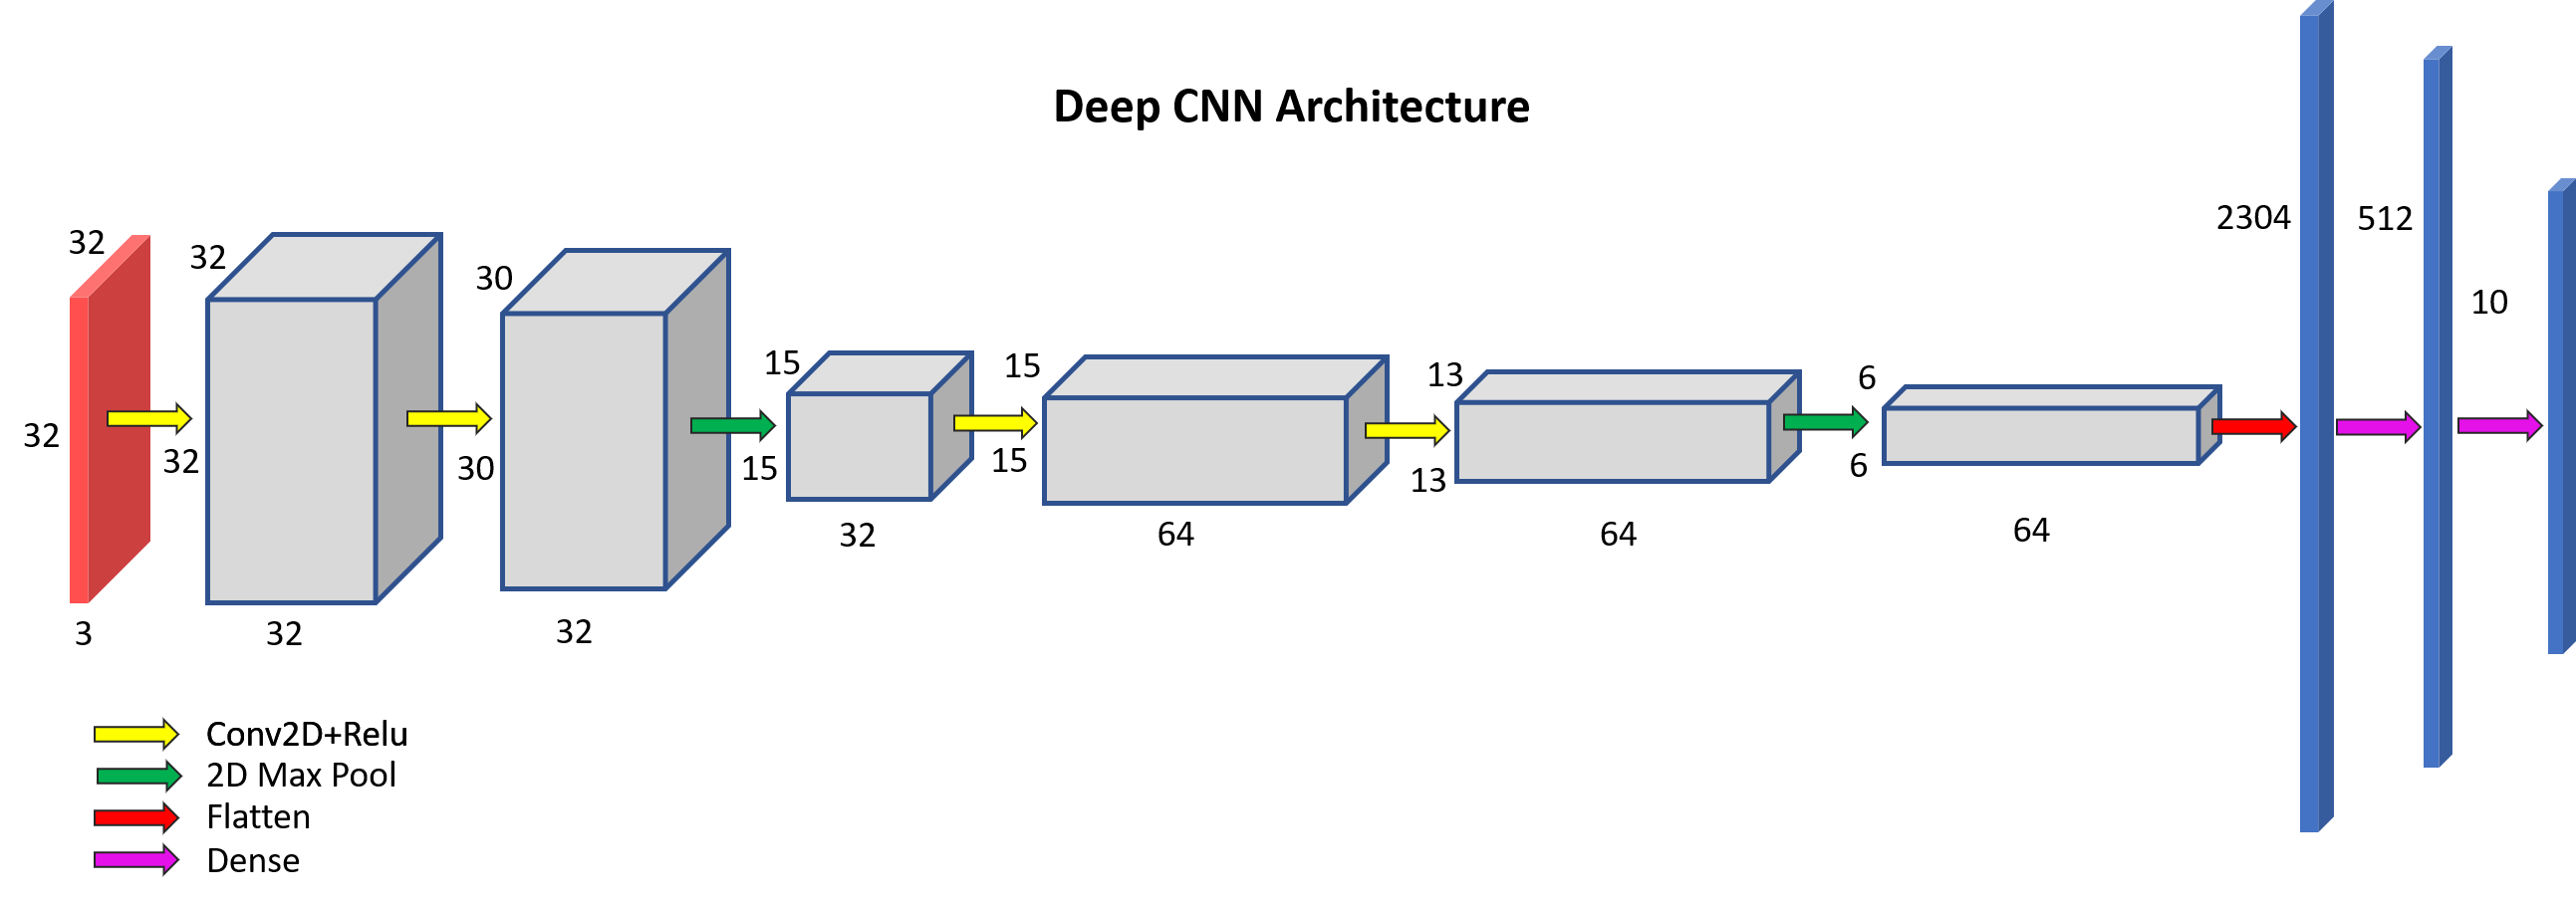
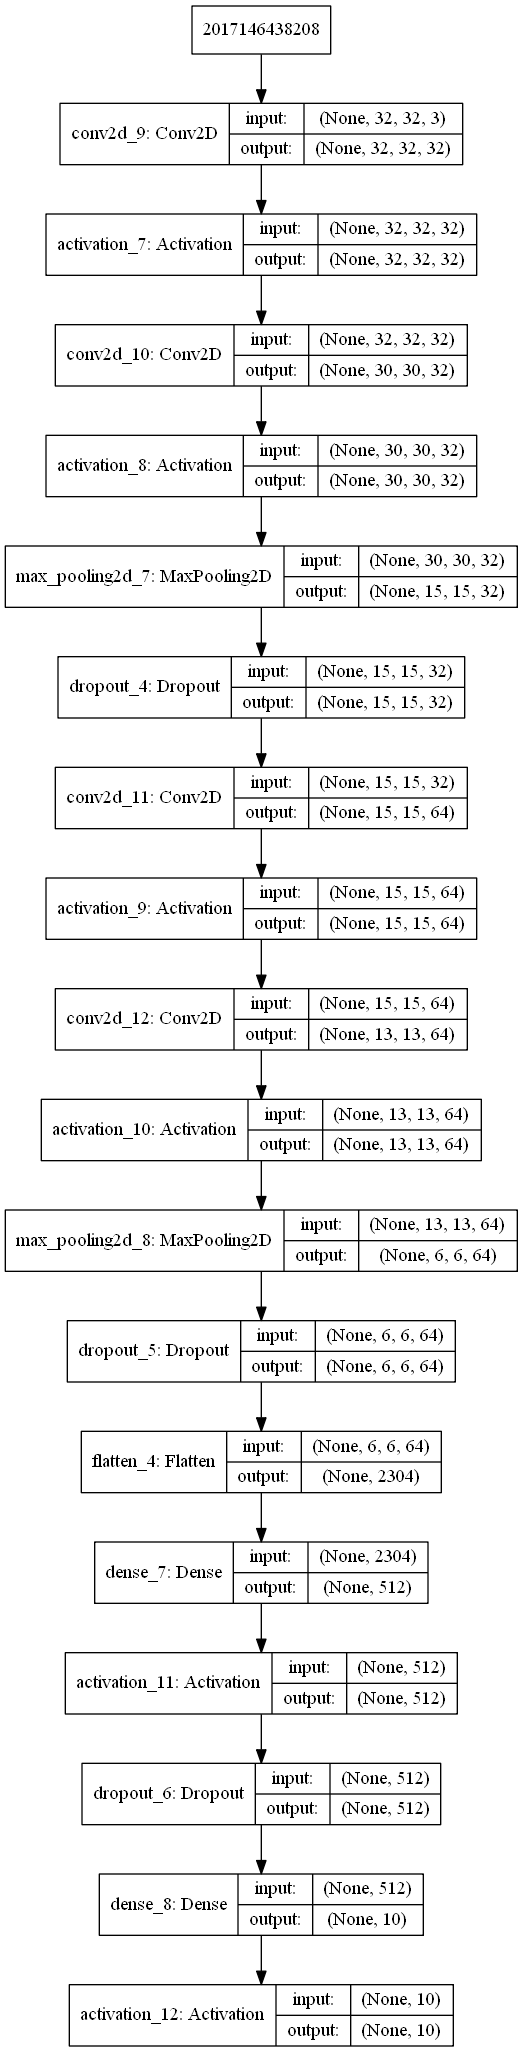

In [7]:
model = compile_deep_CNN_model(input_shape, num_classes, batch_size)
# model.summary()   
plot_model(model, show_shapes=True,to_file='deep_model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Step 2.
## Training Modification:
Modify the provided training code to enable recording and examining additional information per epoch such as training loss and accuracy and validation loss and accuracy.  Implement early stopping based on the validation set.  You may need to use Keras callbacks in this step.   If you are making decisions using the validation data (i.e. early stopping), remember to not use the same validation data to also evaluate the model’s performance.

describe what changes you made here:

#### We added a tensorboard callback, earlystopping, a graphing function and a cutout function for the data augmentation section. We also create a checkpointer to save the weights of the best model (i.e. the model with minimum loss). We have the train_cifar10 function return the history for printing.  Additionally, we have made the MAIN RUNNING CODE a function for reusability. Here we enable selecting the model to run as a option and saving the model with a timestamp. 

In [8]:
def graphHistory(history, title='',metrics=['loss']):
    '''Function for graphing the training and validation accuracy and loss'''
    
    # Plot history for different metrics 
    for strText in metrics:
        fig = plt.figure()

        plt.plot(history.history[strText])
        
        try:
            plt.plot(history.history['val_'+strText])
            plt.legend(['Tr. '+strText, 'Val. '+strText])
        except:
            plt.legend(['Tr. '+strText])
                        
        plt.title('MODEL '+strText.upper() + title)
        plt.ylabel(strText.upper())
        plt.xlabel('Epoch')           
        plt.show()
        
def train_cifar10(model, x_train, y_train, x_val, y_val, batch_size=32,
                  epochs = 200, data_augmentation=False, verbose=0,
                  patience=50, cutout=False,saveBest=False):
    """
    Train a simple deep CNN on the CIFAR10 small images dataset.
    :param model: Keras model to train
    :param x_train:
    :param y_train: categorical (dummy columns)
    :param x_val:  categorical (dummy columns)
    :param y_val:
    :param batch_size: =32
    :param data_augmentation: =False
    :return: trained model
    """
    
    #Add tensorboard for progress tracking. Having trouble getting this to run
    log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    TB = callbacks.TensorBoard(log_dir=log_dir,
                                      histogram_freq=1,
                                      embeddings_freq=1,
                                     embeddings_data = x_train[:100])
    #Creating a checkpointer 
    checkpointer = callbacks.ModelCheckpoint(filepath='keras_cifar10_ROSARIO_LUIS_final_model.hdf5', 
                                   verbose=verbose,save_best_only=True)
    
    #Adding EarlyStopping by monitoring the validation loss
    stopEarly = callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                       verbose=verbose,patience=patience)
    
    if saveBest== True:
        callback = [stopEarly, checkpointer]
    else:
        callback = [stopEarly]
    
    
    
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                  verbose=verbose,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callback,
                  validation_data=(x_val, y_val),
                  shuffle=True)
    else:
        
        if cutout == False:
            print('Using real-time data augmentation.')
            # This will do preprocessing and realtime data augmentation:
            datagen = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False,  # randomly flip images
                fill_mode = 'nearest',
                zoom_range = .2
                )
        else:
            print('Using real-time cutout data augmentation.')
            # This will do preprocessing and realtime data augmentation:
            datagen = ImageDataGenerator( preprocessing_function= get_random_eraser(w = 8, h= 8,
                                                                                    v_l=0, v_h = 1,                                                                                   
                                                                                    pixel_level=True))
            
        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        
        train_generator = datagen.flow(x_train, y_train,batch_size=batch_size)

        # Fit the model on the batches generated by datagen.flow().
        history = model.fit_generator(train_generator,
                                        steps_per_epoch=x_train.shape[0] // batch_size,
                                        callbacks=callback, workers=4,
                                        verbose=verbose,
                                        epochs=epochs,
                                        validation_data=(x_val, y_val)
                                     )
    return model, history


def eval_cifar10(model, x_test, y_test):
    """Loads and evaluates a model on cifar10 dataset
    :param save_dir: subfolder the model is located in
    :param model_file_name: name of the h5 file containing the trained model params
    :return: nothing is returned from this function
    """
    #initialization
    num_predictions = 20  # sample predictions

    print(x_test.shape[0], 'test samples')
    print("y_test shape: ", y_test.shape)

    # Load label names to use in prediction results
    label_list_path = 'datasets/cifar-10-batches-py/batches.meta'
    keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
    datadir_base = os.path.expanduser(keras_dir)
    if not os.access(datadir_base, os.W_OK):
        datadir_base = os.path.join('/tmp', '.keras')
    label_list_path = os.path.join(datadir_base, label_list_path)
    with open(label_list_path, mode='rb') as f:
        labels = pickle.load(f)

    # report evaluation metrics
    evaluation = model.evaluate(x_test, y_test)
    print()
    print('------------------')
    print('Model Accuracy = %.2f' % (evaluation[1]))
    print()
    print('model metrics: ', evaluation)    # change this if you want other metrics

    # make predictions on all test inputs
    predictions = model.predict(x_test)
    print("prediction shape: ", predictions.shape)

    # build class integers from target dummy variables
    actual_class_IDs = np.argmax(y_test, axis=1)
    # build class integers from predicted dummy variables
    predicted_class_IDs = np.argmax(predictions, axis=1)

    print("actual class ID shape: ", actual_class_IDs.shape)
    print("predicted class ID shape: ", predicted_class_IDs.shape)
    print("labels names: ", labels['label_names'][0:10])

    # display label names
    lab_names = np.asarray(labels['label_names'][0:10])

    # generate & print confusion matrix to screen
    cm = confusion_matrix(actual_class_IDs, predicted_class_IDs)
    print(cm)

    # plot confusion matrix in pretty format
    plot_confusion_matrix(cm, class_labels=lab_names, title='Confusion matrix')

    # ...... show some sample predictions (text only) .......
    for predict_index, predicted_y in enumerate(predictions):
        actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
        predicted_label = labels['label_names'][np.argmax(predicted_y)]
        print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                              predicted_label))
        if predict_index == num_predictions:
            break

    return

In [9]:
# =========  MAIN RUNNING CODE  ==================

def runCode(model2run=1, epochs = 10, data_augmentation = False, patience=20, verbose=0,
            batch_size = 256, cutout = False, saveBest=False):
    if __name__ == "__main__":
        print("Starting script.")

        #select activities to perform below
        SHOW_SAMPLES = False  # show examples of CIFAR10 images
        BUILD_MODEL  = False  # overwrites current model with initialized parameters
        TRAIN_MODEL  = False  # overwrites current model by training
        SAVE_MODEL   = False  # saves current model to "model_file_name". should only be used if a model is built or trained
        LOAD_MODEL   = True  # overwrites current model with loaded model
        EVAL_MODEL   = True  # evaluates performance of model on CIFAR10

        # --------- initializtion -----------
        seed = 10
        np.random.seed(seed)

        save_dir = os.path.join(os.getcwd(), 'saved_models')  # subdirectory for saved models
        model_file_name = 'empty_model.h5'  # placeholder - change model name in BUILD_MODEL section

        model = Sequential()  # this is just an empty model to allow code checking - load or train an actual model below

        # ...... load data ......
        x_train, y_train, x_test, y_test, num_classes = load_cifar10_data()
        input_shape = x_train.shape[1:]
        

        # --------- show sample images ----------------
        if SHOW_SAMPLES:
            show_cifar10_images()

        # -------------setup model ---------------
        if BUILD_MODEL:
            # *** choose one of these models for training & comment the others out:
            if model2run == 1:
                # ........ Predesigned Model - shallow CNN ...........
                model = compile_shallow_CNN_model(input_shape, num_classes, batch_size)
                model_file_name = 'keras_cifar10_shallow_trained_model.h5'

            elif model2run == 2:
                #........ Predesigned Model - deeper CNN ...........
                model = compile_deep_CNN_model(input_shape, num_classes, batch_size)
                model_file_name = 'keras_cifar10_deep_trained_model.h5'
            elif model2run == 3:
                # ........ Student Model - you need to write this function ......
                model = compile_student_model(input_shape, num_classes, batch_size)
                model_file_name = 'keras_cifar10_Rosario_final_model.h5'  # (insert your lastname)
            else:
                return 0
            
            #-------------end setup model---------------
            print("Model Initialization & Compile  Complete")

        # ------------ Execute Training on compiled model -----------------------
        if TRAIN_MODEL:
            model.summary()
            print('Model Training Initiated...')
            epochs = epochs
            val = int(1e4)
            x_val, y_val = x_train[0:val],y_train[0:val]  # you can use split val data from training data instead if you wish
            x_train, y_train = x_train[val:] , y_train[val::]
            model, history = train_cifar10(model, x_train, y_train, x_val,
                                  y_val, batch_size, epochs, 
                                  data_augmentation,
                                  verbose=verbose, 
                                  patience=patience,
                                  cutout=cutout,
                                  saveBest=saveBest)
            print("Model Training Complete")
            
            #Plot the loss and accuarcy of the model
            graphHistory(history,title='',metrics=['acc','loss'])
    
        # ------------- save the trained model ---------------------
        if SAVE_MODEL:
            timeStamp = time.strftime("%Y_%m_%d_%H_%M_", time.localtime())
            save_CNN_model(model, save_dir, timeStamp+model_file_name)               

        # ---------- load a saved model later for evaluation --------
        if LOAD_MODEL:
            # Uncomment only the filename you want to load
            if model2run == 1:
                model_load_file_name = 'keras_cifar10_shallow_trained_model.h5'  # put the right model name to load here
            elif model2run == 2:
                model_load_file_name = 'keras_cifar10_deep_trained_model.h5'
            elif model2run == 3:
                model_load_file_name = 'keras_cifar10_Rosario_final_model.h5'  
            elif model2run == 4:
                model_load_file_name = 'keras_cifar10_Rosario_final_model2.h5'  
            else:
                return 0
                
            model = load_CNN_model(save_dir, model_load_file_name)

        # ---------- evaluate the trained model on the test data ----------
        if EVAL_MODEL:
            eval_cifar10(model, x_test, y_test)

        #at end of code, this call to show keeps images on the screen
        plt.show(block=True)

        print("Done. Exiting...")
        

# 3.	Existing Architecture Training Check: 

## Confirm that the training works for shallow model

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_shallow_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 3s 2ms/step - loss: 2.2520 - accuracy: 0.6719

------------------
Model Accuracy = 0.67

model metrics:  [2.252037763595581, 0.6718999743461609]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[734  19  44  22  20  10  17   9  85  40]
 [ 29 753  13  20   4   9  19   4  30 119]
 [ 58  11 574  68 106  58  60  34  17  14]
 [ 20  13  70 472  81 176  79  45  15  29]
 [ 27   5  72  66 614  44  58  84  17  13]
 [ 20   2  58 190  61 560  30  61  12   6]
 [ 11   9  43  60  

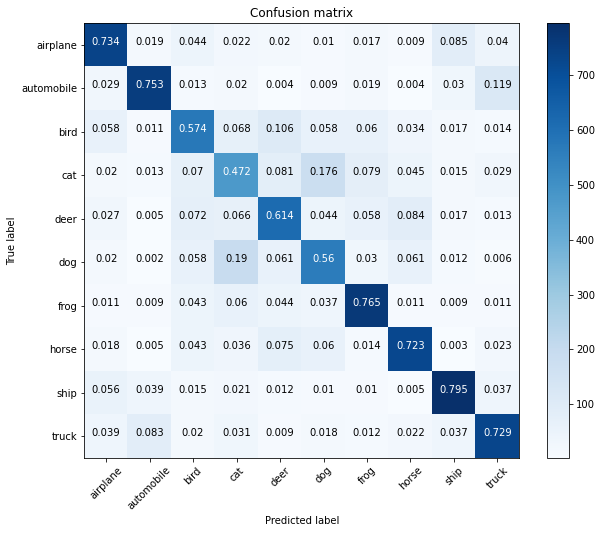

Actual Label = cat vs. Predicted Label = dog
Actual Label = ship vs. Predicted Label = airplane
Actual Label = ship vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = deer
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Lab

In [10]:
%%time
runCode(model2run=1, epochs = 10, data_augmentation = False)


## Confirm that the training works for deep model

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_deep_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 2ms/step - loss: 0.7316 - accuracy: 0.7695

------------------
Model Accuracy = 0.77

model metrics:  [0.7316046357154846, 0.7695000171661377]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[858   1  18  14  12   4   7   8  64  14]
 [ 45 781   2   6   1   3  15   2  46  99]
 [109   2 574  43  74  82  84  15  11   6]
 [ 35   0  27 581  48 201  70  16  13   9]
 [ 28   0  36  54 751  33  58  28  11   1]
 [ 12   1  22 112  29 781  22  18   2   1]
 [  9   0  22  43  17

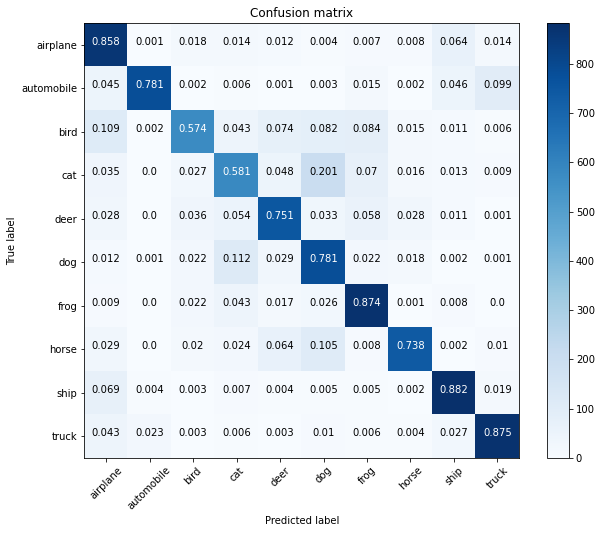

Actual Label = cat vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = frog
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = truck
Actual Label = frog vs. Predicted Label = bird
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = airplane
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = horse vs. Pr

In [11]:
%%time
runCode(model2run=2, epochs = 10, data_augmentation = False)

# PERFORMANCE DOCUMENTATION

# STEP 4.	
## Existing Architecture Performance Evaluation: 

Using the provided code, train and evaluate the two provided Keras CNNs (shallow, deep) on the CIFAR10 dataset on 200 epochs.  Make sure data_augmentation = False.  Produce and discuss the training and validation curves.  What can you tell about these models from these curves.  Do they have enough capacity?  Were they trained long enough?  You may desire to increase the number of training epochs beyond 200 if you have time and the training performance was still improving.  Report standard classification metrics including loss and accuracy as well as a confusion matrix of performance on the test data. Compare the performances of these simple models with best architectures on CIFAR10 (state of the art performance): https://en.wikipedia.org/wiki/CIFAR-10 

insert your response here... note that you will probably need to save & reload performance information recorded during training/test of these networks in order to recreate figures & provide performance info here.  Feel free to use code cells to do this as necessary:  

# Training the shallow model

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_shallow_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 2ms/step - loss: 2.2520 - accuracy: 0.6719

------------------
Model Accuracy = 0.67

model metrics:  [2.252037763595581, 0.6718999743461609]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[734  19  44  22  20  10  17   9  85  40]
 [ 29 753  13  20   4   9  19   4  30 119]
 [ 58  11 574  68 106  58  60  34  17  14]
 [ 20  13  70 472  81 176  79  45  15  29]
 [ 27   5  72  66 614  44  58  84  17  13]
 [ 20   2  58 190  61 560  30  61  12   6]
 [ 11   9  43  60  

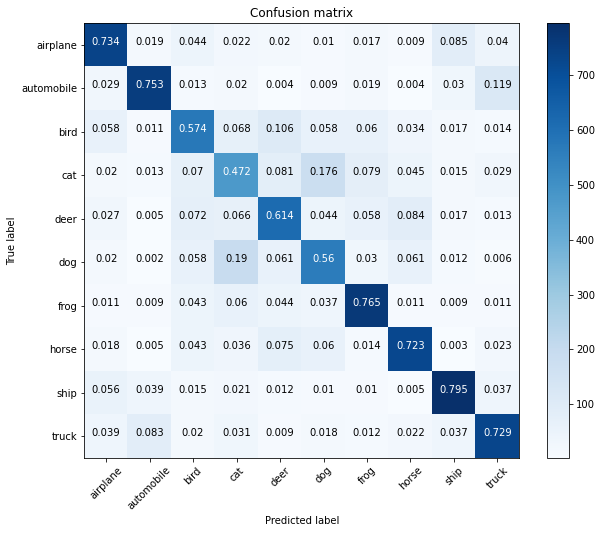

Actual Label = cat vs. Predicted Label = dog
Actual Label = ship vs. Predicted Label = airplane
Actual Label = ship vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = deer
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Lab

In [12]:
%%time
#Shallow model with no augmenation 
runCode(model2run=1, epochs = 200, data_augmentation = False, verbose=0, 
       patience=50, batch_size=32)

#### As can be seen from the model accuracy and loss plots shown above, this shallow architecture has problems with over fitting on the training  data. The factor that the training accuracy reaches almost 100% means the model has the sufficient capacity but even if it was trained for longer, the validation accuracy would not improve. 

#### For the none-augmentation version the model accuracy  is 0.67 and the loss is 1.712. This model falls 33% short of the current state-of-the-art model designed at Google Brain, which achieved a 99% classification accuarcy on the CIFAR-10 dataset. The confusion matrix and the history plot are displayed above. 

#### We also tried increasing the batch size to 128 and noticed that the model converges to similiar results but at a larger amount of epochs. This is due to the fact that larger batch sizes induce smaller back propagation weigth updates. Ther results are shown below.


Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_shallow_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 2ms/step - loss: 2.2520 - accuracy: 0.6719

------------------
Model Accuracy = 0.67

model metrics:  [2.252037763595581, 0.6718999743461609]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[734  19  44  22  20  10  17   9  85  40]
 [ 29 753  13  20   4   9  19   4  30 119]
 [ 58  11 574  68 106  58  60  34  17  14]
 [ 20  13  70 472  81 176  79  45  15  29]
 [ 27   5  72  66 614  44  58  84  17  13]
 [ 20   2  58 190  61 560  30  61  12   6]
 [ 11   9  43  60  

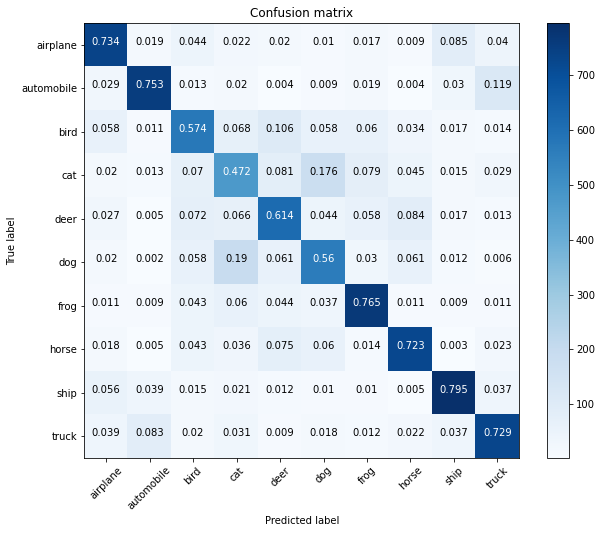

Actual Label = cat vs. Predicted Label = dog
Actual Label = ship vs. Predicted Label = airplane
Actual Label = ship vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = deer
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Lab

In [13]:
%%time
#Shallow model with no augmenation and 128 batch size

EPOCHS_TO_RUN = 2   #set to 2 for testing code;  set to 200 for real solution

runCode(model2run=1, epochs = EPOCHS_TO_RUN, data_augmentation = False, verbose=0, 
       patience=25, batch_size=128)

# Training the deep model

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_deep_trained_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 2ms/step - loss: 0.7316 - accuracy: 0.7695

------------------
Model Accuracy = 0.77

model metrics:  [0.7316046357154846, 0.7695000171661377]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[858   1  18  14  12   4   7   8  64  14]
 [ 45 781   2   6   1   3  15   2  46  99]
 [109   2 574  43  74  82  84  15  11   6]
 [ 35   0  27 581  48 201  70  16  13   9]
 [ 28   0  36  54 751  33  58  28  11   1]
 [ 12   1  22 112  29 781  22  18   2   1]
 [  9   0  22  43  17

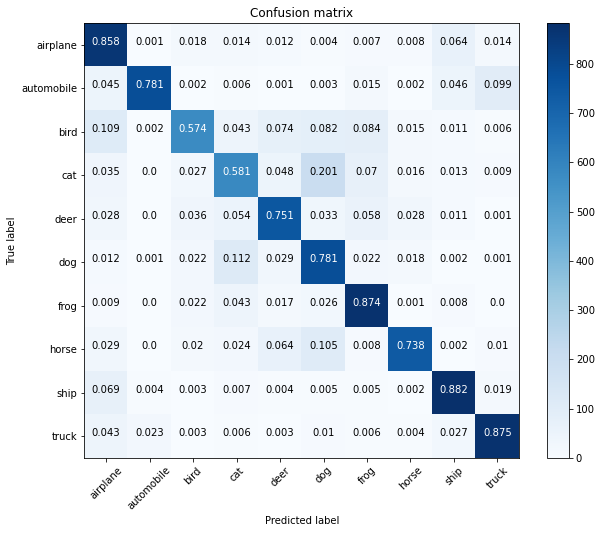

Actual Label = cat vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = frog
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = truck
Actual Label = frog vs. Predicted Label = bird
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = airplane
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = horse
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = horse vs. Pr

In [14]:
%%time
#Deep model with no augmenation 
runCode(model2run=2, epochs = EPOCHS_TO_RUN, data_augmentation = False, verbose=0, 
       patience=50, batch_size=32)

#### This model seens to have enough capacity and could reach a higher classification accuracy on training if left to run for more epochs. It also has better classification accuracy than the shallow model but it starts overfitting after 40 epochs. This model has a validation loss of 0.73% and a classification accuarcy of 0.77% which is 23% behind the current state-of-the-art model as mentioned earlier. The validation loss and accuarcy history and the confusion matrix are plotter above. 

## STEP 5:  Literature Review
Using the Wikipedia link listed below, and/or a literature search you conduct, locate and discuss at least 3 papers (conference or journal) which provide different approaches to tackling classification on the CIFAR10 dataset and have very good performance. In your ipython notebook, compare and contrast their architectures and rationale for the researchers choices.  Include images or use other ways to describe the architectures.  Compare/contrast model performances.


#### Improved Regularization of Convolutional Neural Networks with Cutout

While many focus on creating deeper or denser architectures in order to increase the classification accuracy in dataset such of CIFAR 10 and CIFAR 100, the following paper focuses on using previous architectures with more clever data augmentation techniques. DeVires and Taylor [1](https://arxiv.org/abs/1708.04552), introduce a new type of data augmentation technique for suppressing a network's tendency to overfit on the training data.  The technique consists of occluding random sections of an image as is shown in the figure below. The uniqueness of this technique, according to DeVires and Taylor, is that a contiguous section of the image is cut out rather than zeroing out individual pixels. Because neighboring pixels carry similar information, dropping one of them does not stop of the network of learning from the neighbors.

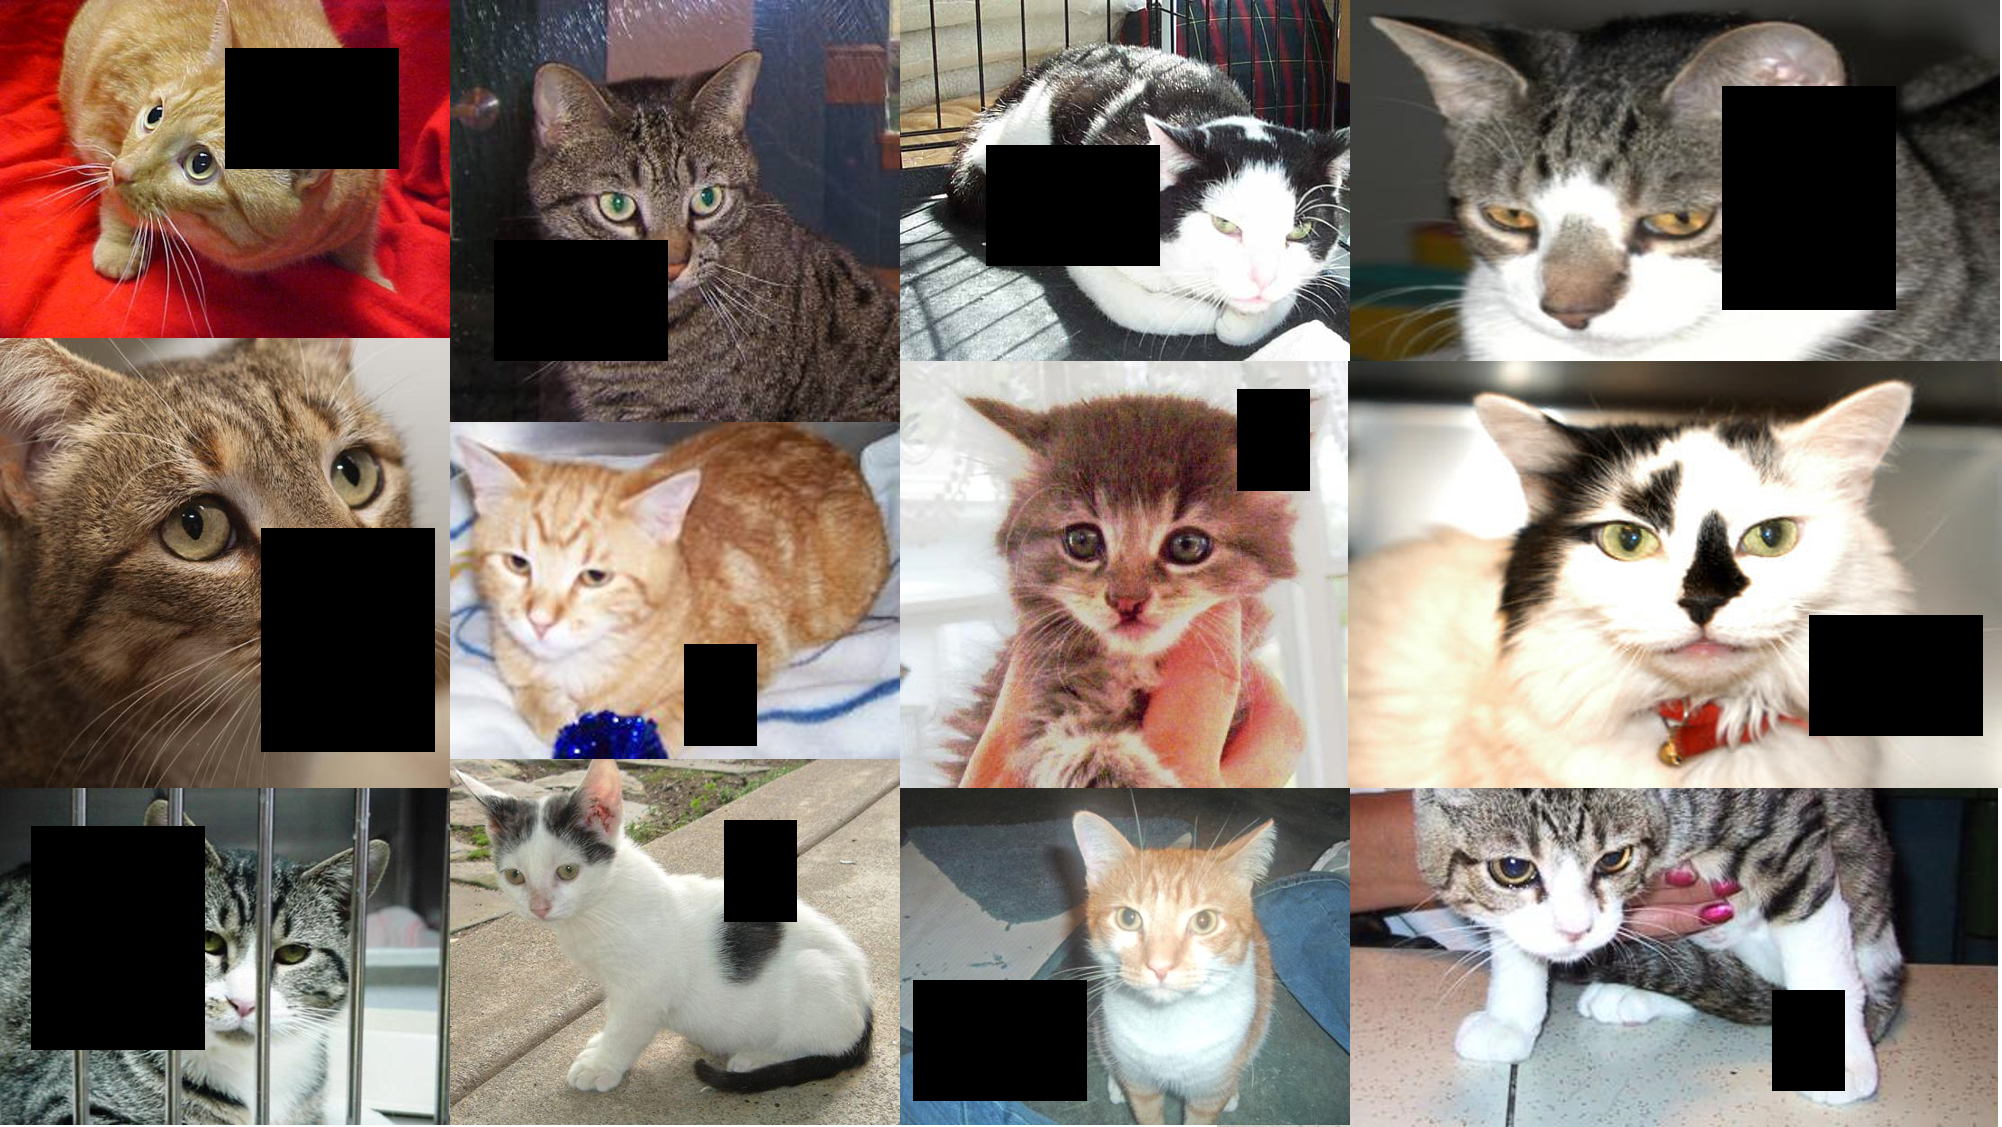

They found that the cutout size is an important hyperparameter and that cutout should be applied with <50% probability rate. Additionally, they discovered that adding random colors in the occluded section provides higher performance that simply creating black patches. The plots below illustrate the accuracy vs patch size for the CIFAR 10 and CIFAR 100 datasets. Notice that in the CIFAR 10 dataset a 16x16 patch produces a 96.9% validation accuracy with a 95% confidence interval while in the case of the CIFAR 100, a 8x8 patch size produced the best results.


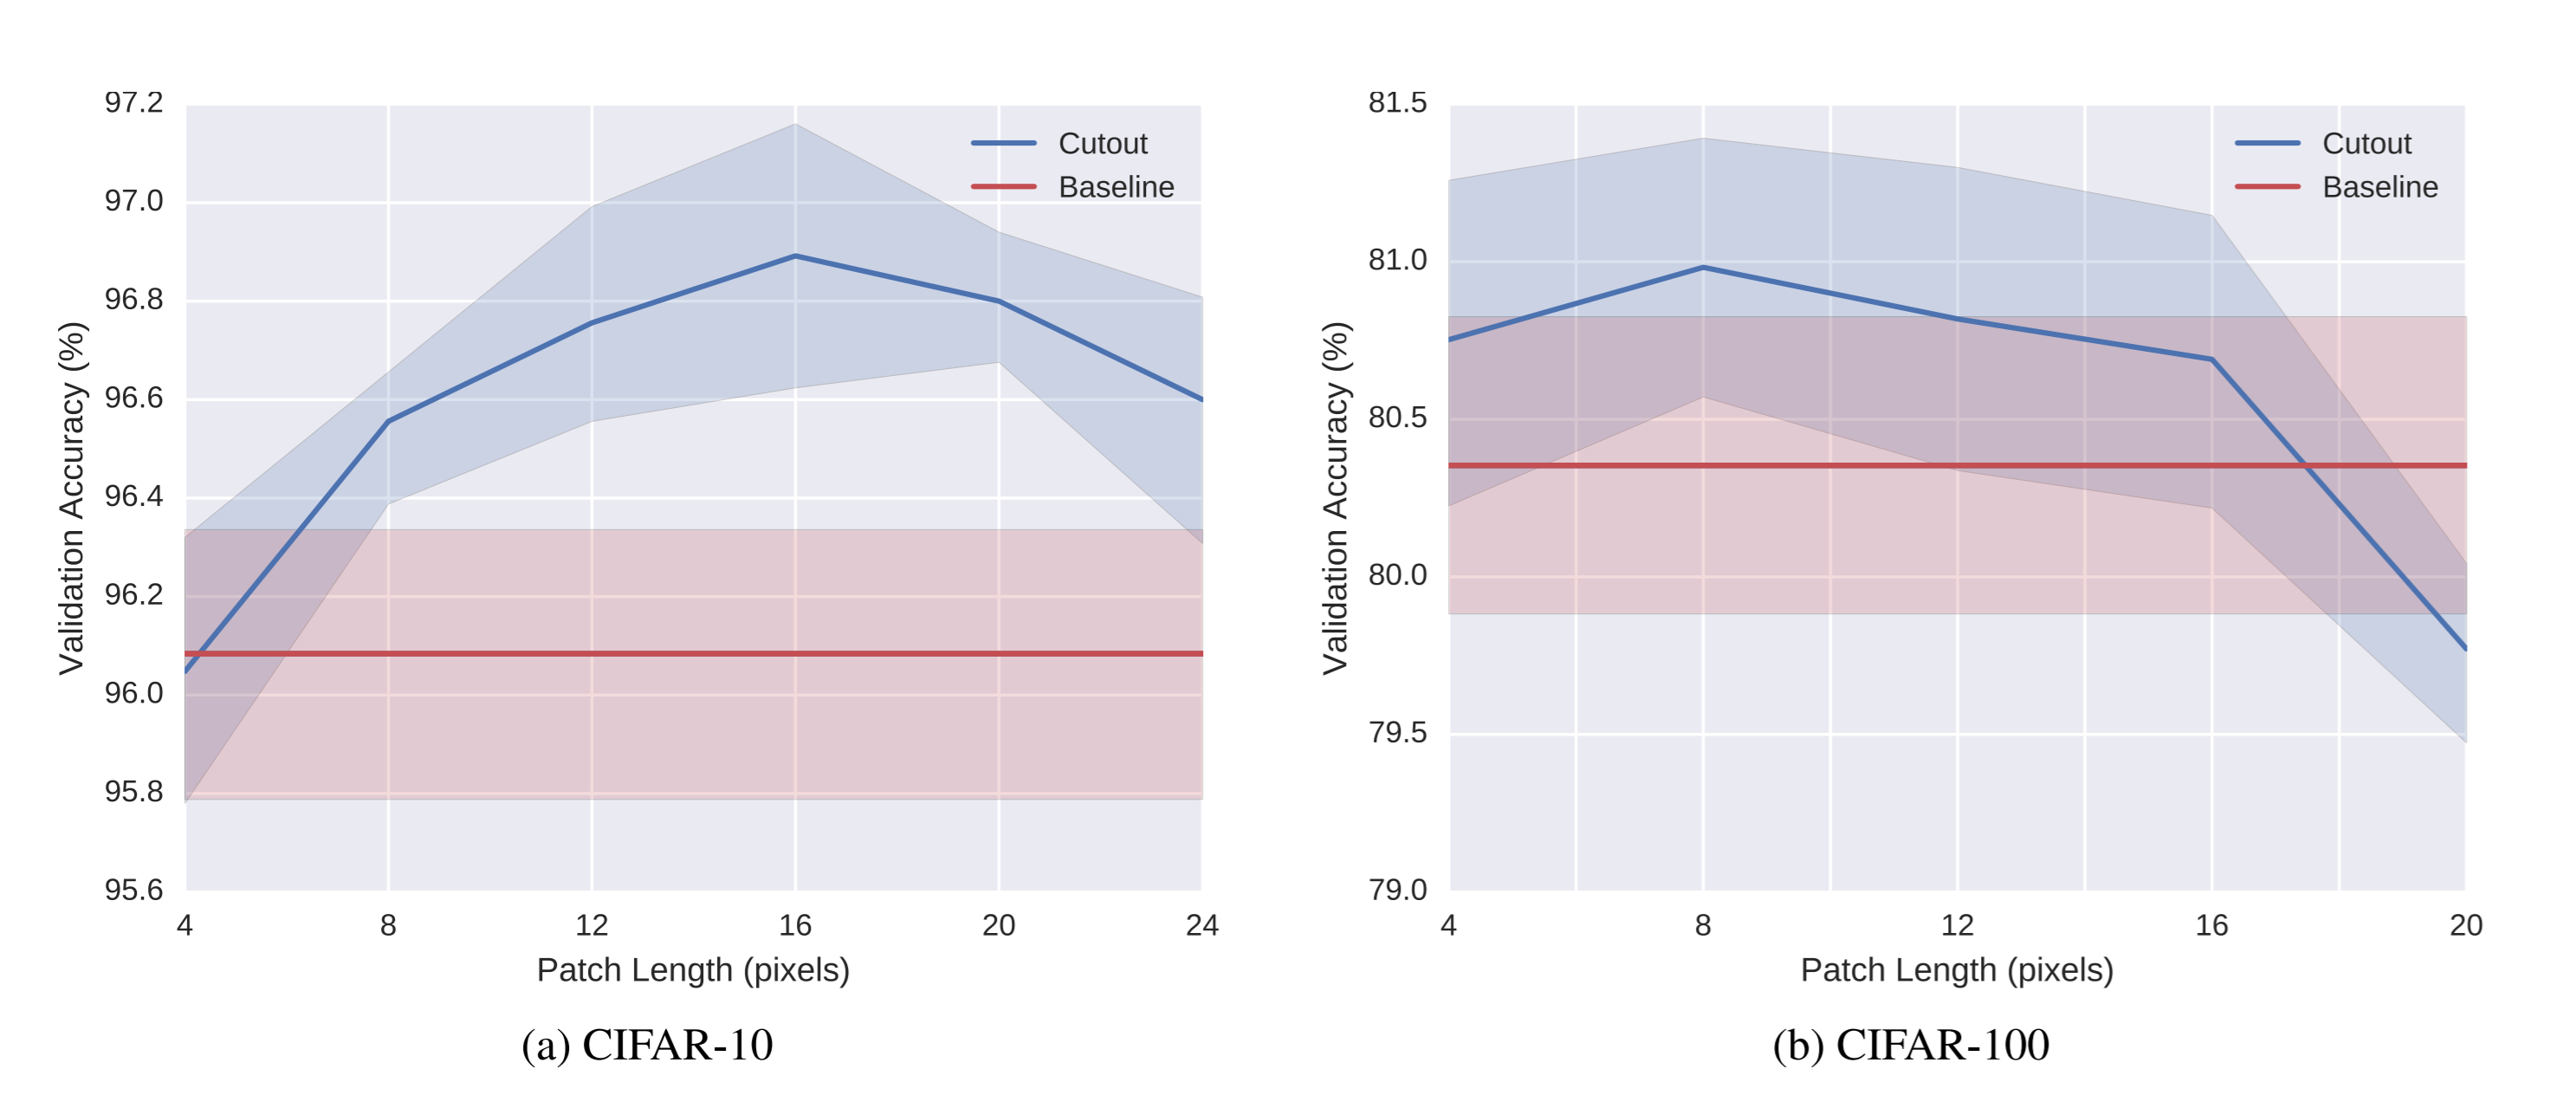
Image source:[1](https://arxiv.org/abs/1708.04552)


To evaluate the cutout technique on the CIFAR datasets, DeVires and Taylor trained various models on multiple datasets. The results are shown in the table below. Here we can see the Test error for models trained using only cutout (+) vs using mirror and crop as data augmentation.

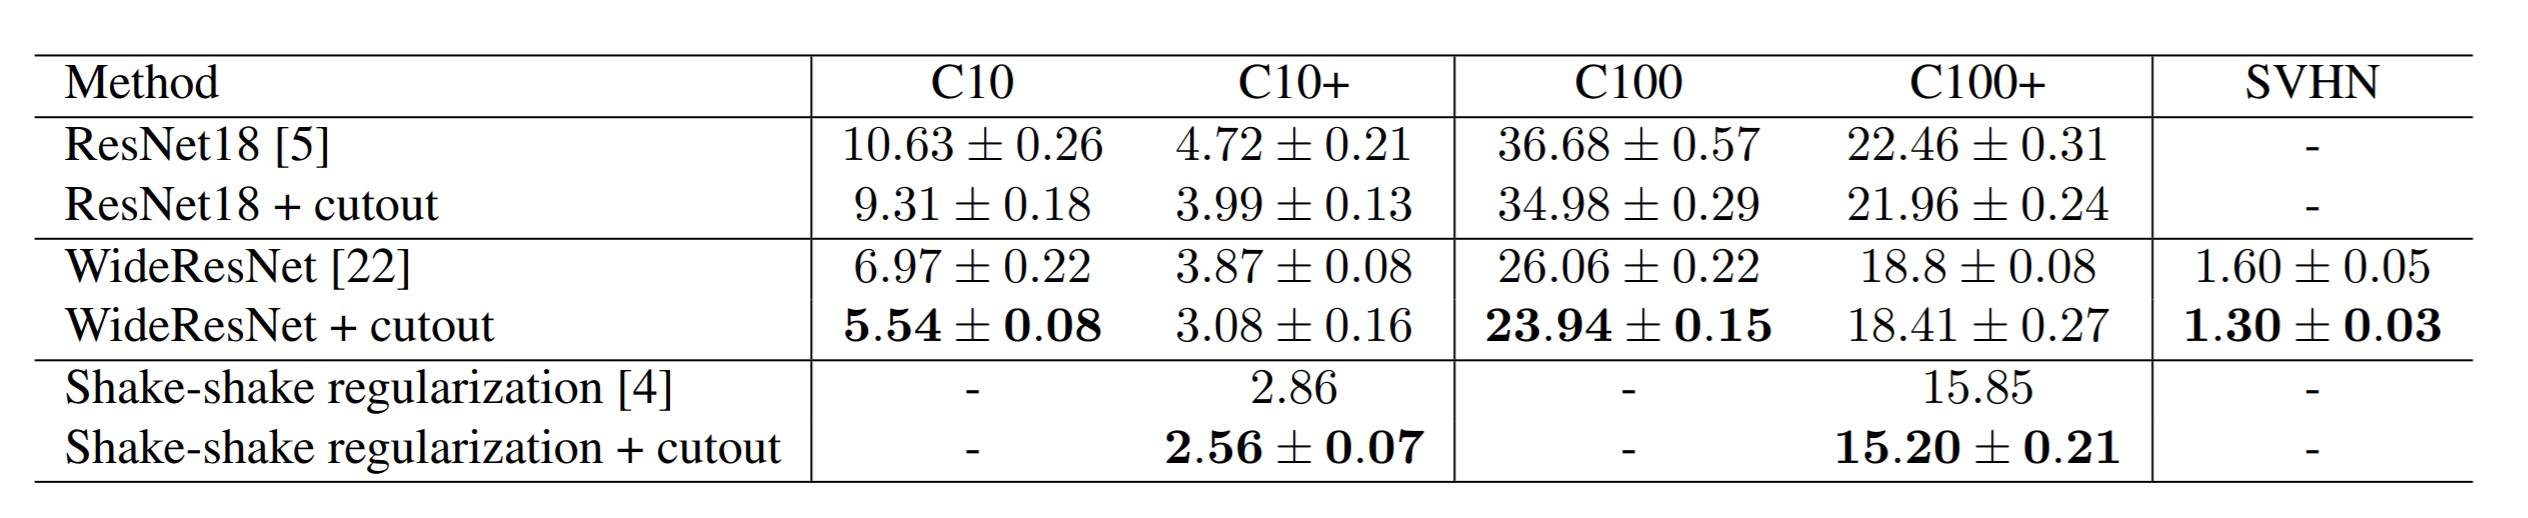
Image source:[1](https://arxiv.org/abs/1708.04552)

#### GPipe: Efficient Training of Giant Neural Networks using Pipeline Parallelism

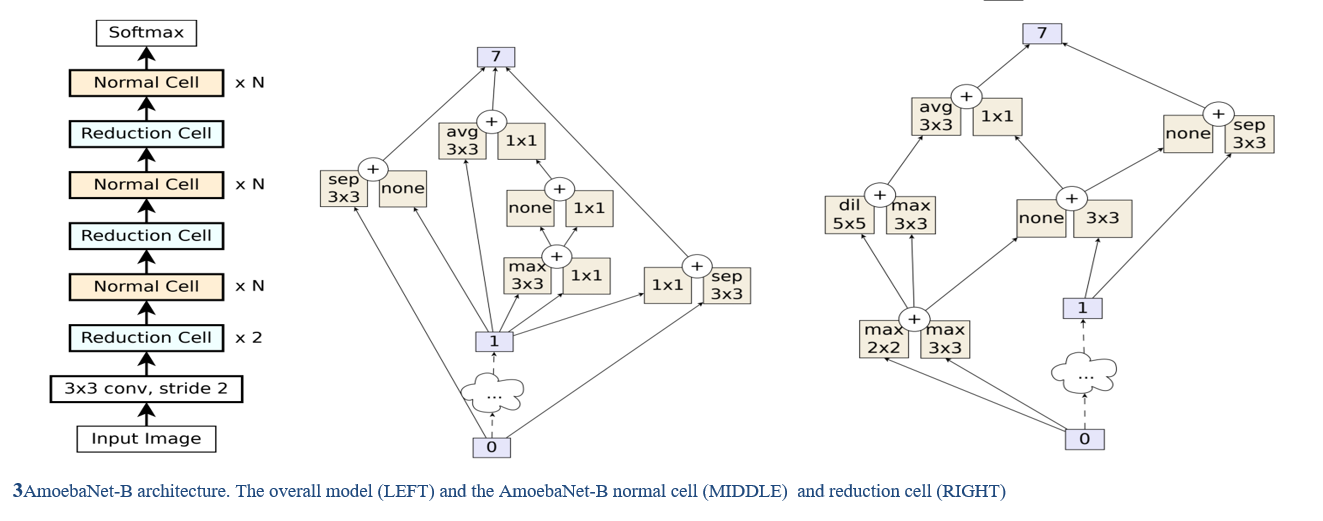
Image source:[4](hhttps://arxiv.org/pdf/1802.01548.pdf)

Huang et al [2](https://arxiv.org/pdf/1811.06965.pdf) from the Google Brain team, created a library name GPipe, that enables scaling model parallelism for training giant deep learning models as the AmoebaNet-B model shown above. This library achieves upto 3.5 times speedups using 8 accelerators on Googles TPU -v2 which have a total of 64 GB of memory and can support upto 1.8 billion parameter models. Taking advantage of this speedup, they can train bigger models or process higher resolution images, which has been found to increase the classification accuracy. They demonstrate the power of giant models by increasing the number of parameters of an AmoebaNet to 557 million and training it using input images of size 480x480 on the ImageNet 2012 dataset. They reached a state of the art (SOTA) 84.3% top-1/ 97.0% top-5 accuracy on this dataset.

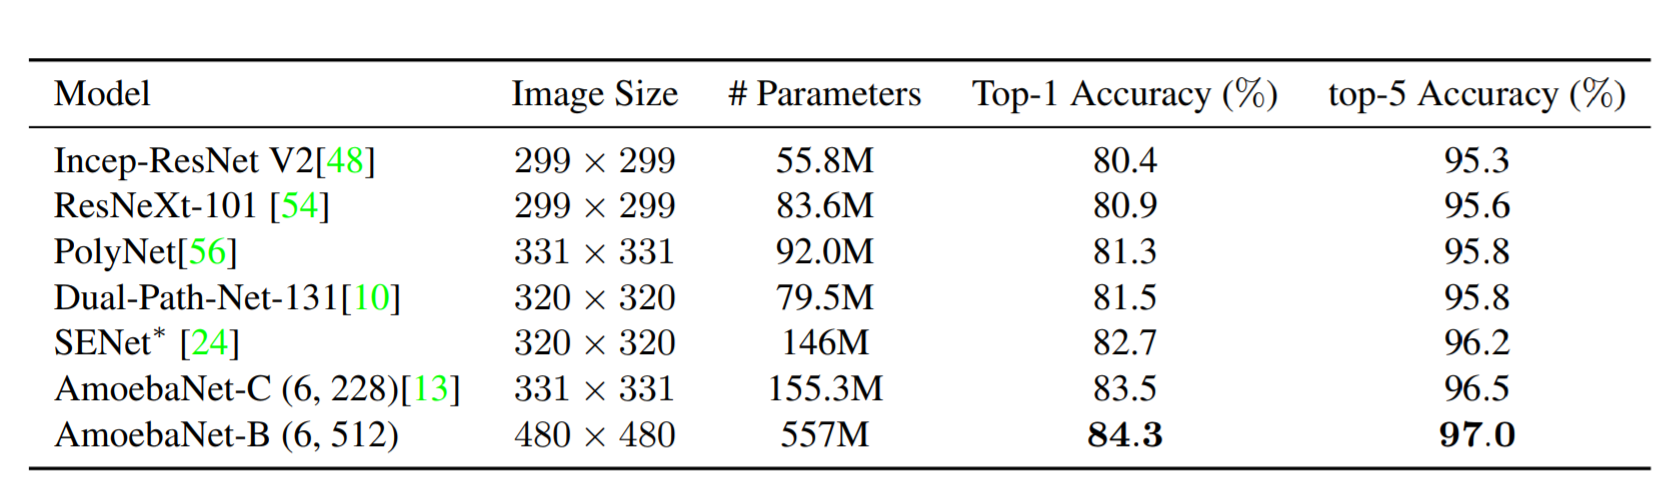
Image source:[2](https://arxiv.org/pdf/1811.06965.pdf)

After training the model for the ImageNet dataset, they implmented transfer learning to finetuned several similiar datasets. For the CIFAR 10 dataset, they reached 99% accuracy using transfer learning as shown below. 

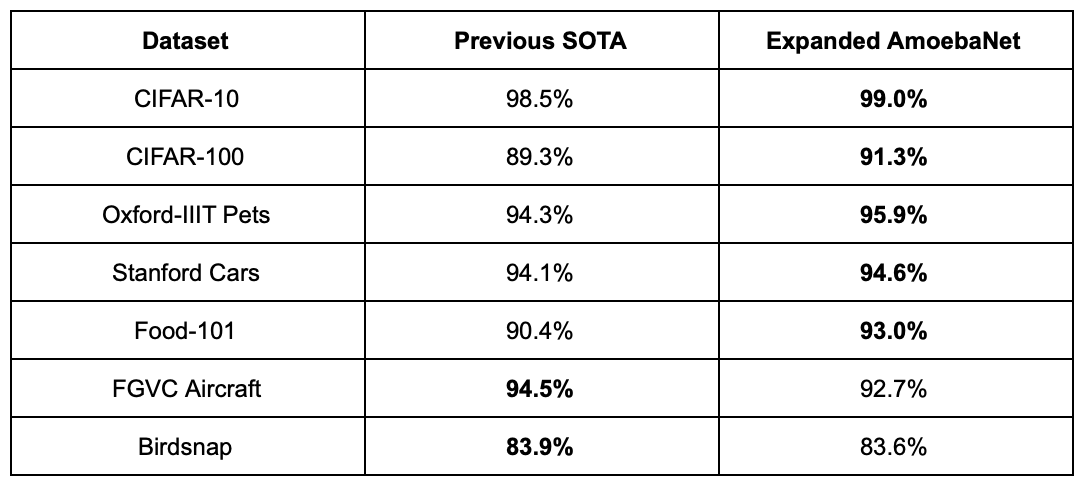
Image source:[2](https://arxiv.org/pdf/1811.06965.pdf)


#### AutoAugment: Learning Augmentation Strategies from Data

Cubuk et al from the Google Brain found that augmentation improvement of a particular dataset are not transferable to other datasets and therefore propose an automated data augmentation algorithm. They implemented a search algorithm based on Reinforcemente leanring to find the best augmentation policy for individual datasets. The operations they are searching over are ShearX/Y, TranslateX/Y, Rotate, AutoContrast, Invert, Equalize, Solarize, Posterize, Contrast, Color, Brightness, Sharpness, Cutout and Sample Pairing. Each operation has 10 variants that occur with a uniform probability of 1/11. Finally, each policy consists of 2 operation and they are looking for five policies. As stated in the paper, the search space is $(16x10x11)^{2*5} \approx 2.9 x 10^{32}$.  

For the purpose of validating their automated data augmentation algorithm, they used different architectures and several datasets, these are shown in the table below. Here we can see the Test set error when using baseline augmentation (Horizantal flip with 50% probability, and zero-padding and random crops), Baseline and Cutout, or by using AutoAugment to find the most appropiate augmentation policy. For CIFAR 10, the AutoAugment picked mostly color-based transformations like equalize, AutoContrast, Color, and Brightness. The results are shown in the table below.

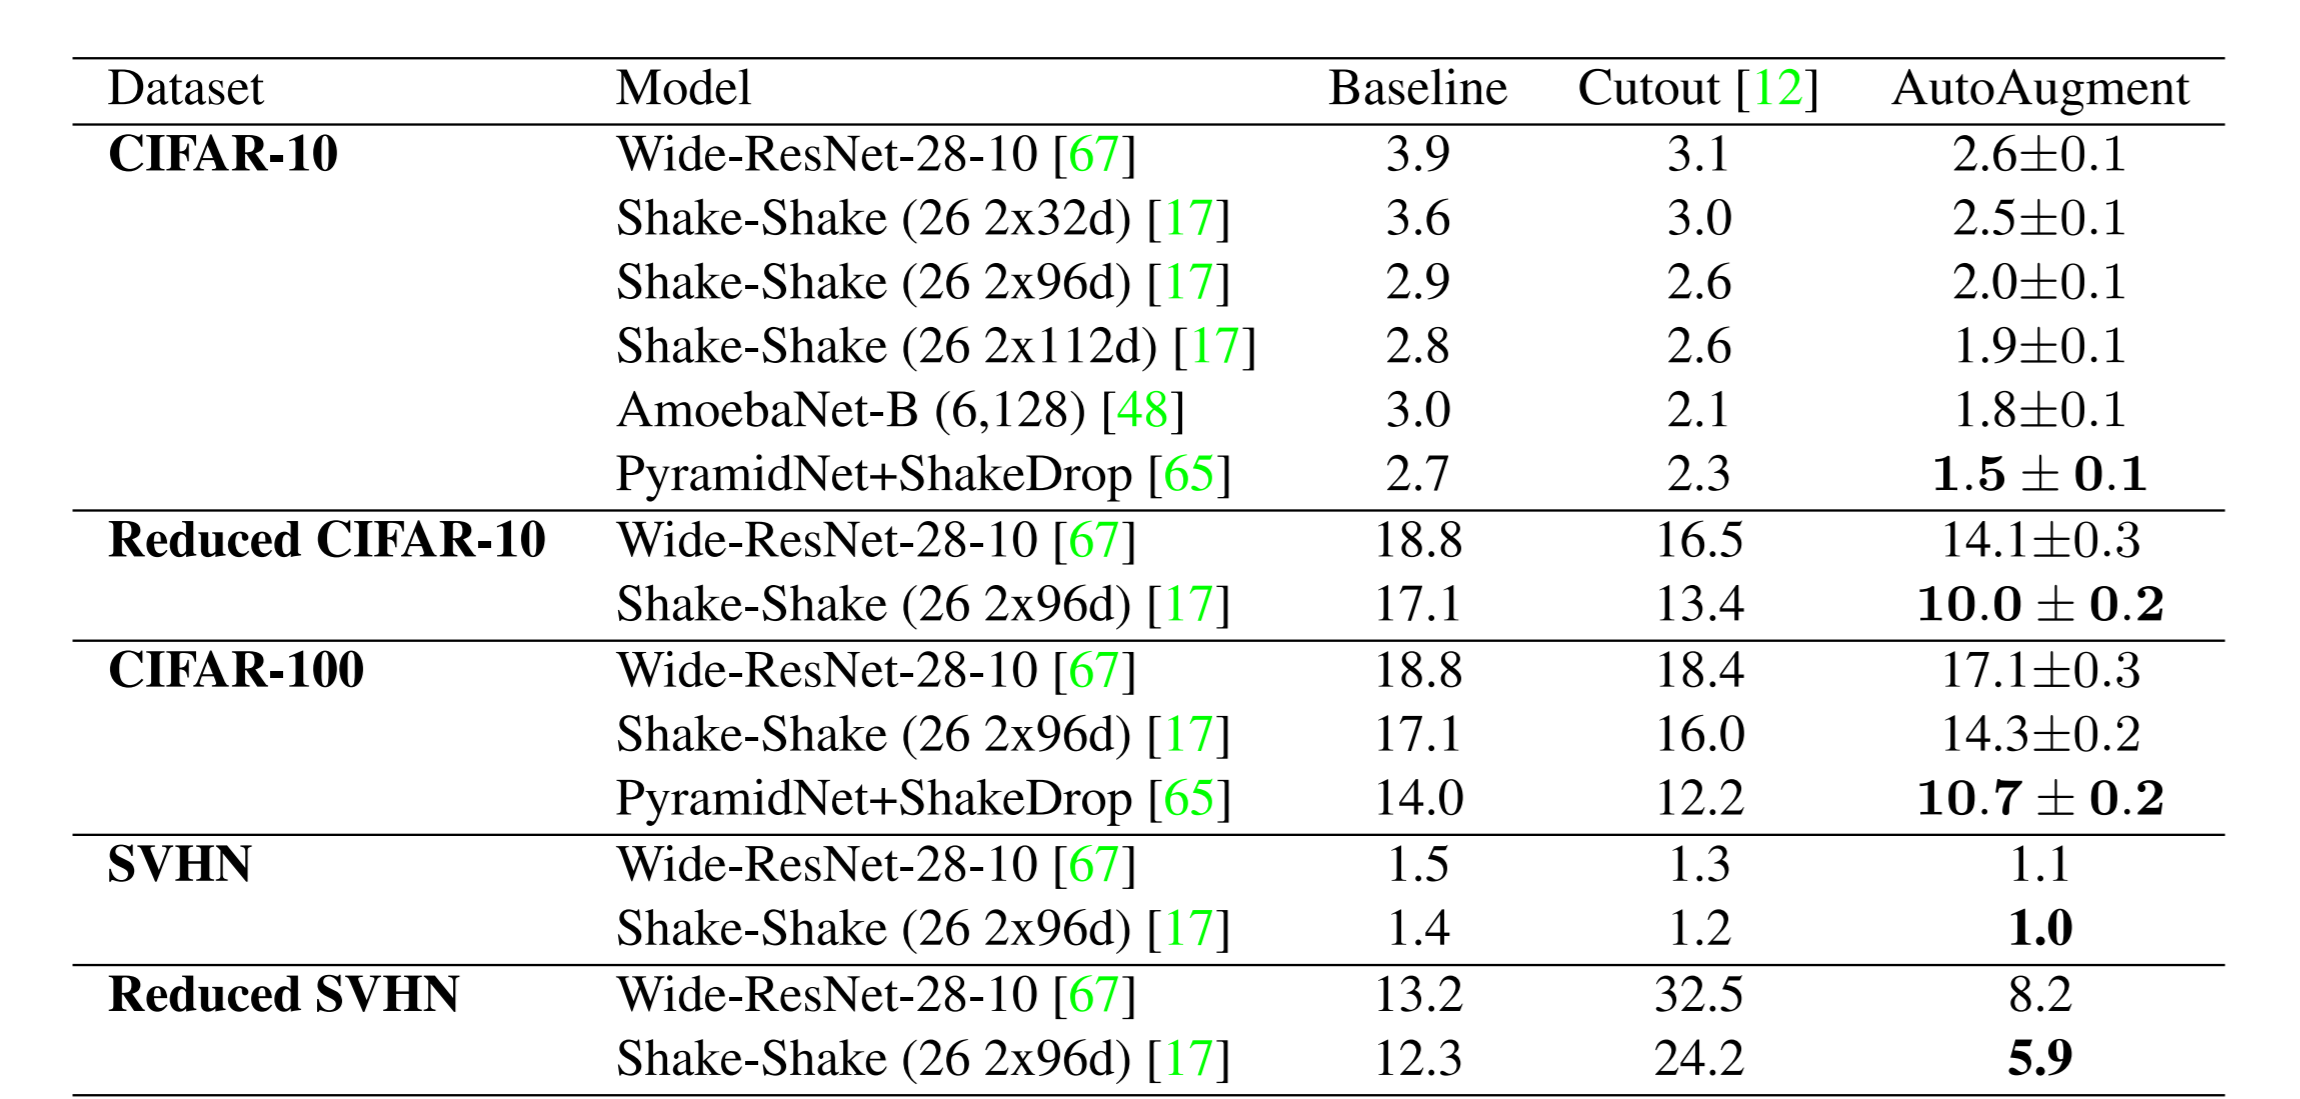
Image source:[3](https://arxiv.org/pdf/1805.09501.pdf) The lower the error rate, the better.


#### Method comparision
As can be seen from the table below, as time progresses, newer techniques, and both software and hardware advancements will enable higher accuracy rates in such tasks as image classification.  DeVires and Taylor [1](https://arxiv.org/abs/1708.04552) improved the Shake-Shake Regularization architecture from 97.14% to 97.44 by a simple augmentation process. Cubuk et al [3](https://arxiv.org/pdf/1805.09501.pdf), further closed the gap, by over 1%, achieving  98.52% by searching for the proper augmentation operations. Finally, Huang et al [2](https://arxiv.org/pdf/1811.06965.pdf) demonstrated the more GPU's can enable processing higher resolution images and bigger networks and reached 99% accuracy. While these papers differ in methods and did not go into the development of new architectures, we have learnt that transfer learning and reusing pretrained networks can save countless hours of work and can still provide SOTA results.
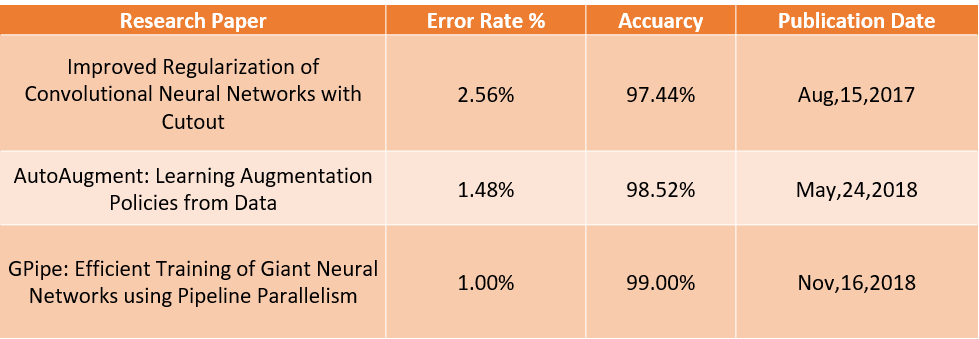



Bibliography:

[1] Terrance, DeVries,; W., Taylor, Graham (2017-08-15). "Improved Regularization of Convolutional Neural Networks with Cutout". [arXiv:1708.04552](https://arxiv.org/abs/1708.04552.pdf)

[2]  Huang, Yanping; Cheng, Yonglong; Chen, Dehao; Lee, HyoukJoong; Ngiam, Jiquan; Le, Quoc V.; Zhifeng, Zhifeng (2018-11-16). "GPipe: Efficient Training of Giant Neural Networks using Pipeline Parallelism"
[arXiv:1811.06965.pdf](https://arxiv.org/pdf/1811.06965.pdf)

[3] Wistuba, Martin; Rawat, Ambrish; Pedapati, Tejaswini (2019-05-04). "A Survey on Neural Architecture Search". 
[arXiv:1905.01392](https://arxiv.org/pdf/1905.01392.pdf)

[4] Real, Esteban; Aggarwal, Alok; Huang, Yanping, Le, Qouc V. (2019-02-16). "Regularized Evolution for Image Classifier Architecture Search". 
[arXiv:1802.01548](https://arxiv.org/pdf/1802.01548.pdf)

## STEP 6: Student Model
Your architecture can be inspired by other architectures you might have seen, but it should be your own.  Code up your model in Keras in the cell below:


In [15]:
def compile_student_model(input_shape, num_classes, batch_size=32, epochs=200):
    """Compiles a student-designed CNN: with various layers
    :param input_shape: tensor shape of the input (not including observation count)
    (3 dim for 3 channel color images)
    :param num_classes: name of the h5 file containing the trained model params
    :param batch_size=32: size of the batches used for training
    :return: compiled model
    
    Info on BatchNormalization
    https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
    """

    model = Sequential()
    model.add(Conv2D(32, (3, 3), use_bias=False, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))    
    model.add(MaxPooling2D(pool_size=(2, 2)))   
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu")) 
    model.add(Dropout(0.25))
    
    model.add(Dense(num_classes, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("softmax")) 
    
    
    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    # compile the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model


### Step 6 (continued) Student Model Design Description:
Cite any sources that inspired your design.  Consider using/altering the various layers (e.g. conv2D, activation, pooling, dropout) as well as the optimizer selection and settings. Develop a diagram (e.g. using architecture display tools or Powerpoint, saved as .png) of the layers like you’ve seen in class or on the internet.  Document your design and your decision rationale.    In a markdown cell, describe the architecture and their parameters.  How many parameters are there?  What other features are present in these models.  How do they differ?  What is your conjecture about their expected performance on the CIFAR10 dataset compared to the instructor-provided architectures?  Compared with state of the art performance?  

insert your documentation for step 6 here:

#### We wanted to built upon the deep model provided in this assignment and test out different techniques learnt from literature. The architecture of our model shown below, illustrates that our model contains three convolutional layers, each followed by a max pooling layer and finally a flattening layer followed by a dense layer with ‘softmax’ as the activation function. 

#### One of the first techniques that we learnt is that BatchNormalization can speed up convergence time as well as prevent overfitting and handle vanishing gradients.[5](https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/)  These layers are insert between every Conv2D and the activation layer, also in between of every Dense and activation layer. According to Chollet [7](https://www.manning.com/books/deep-learning-with-python), this layer normalizes to zero mean and unit variance and it helps with gradient propagation. 

#### The second technique learnt is that we should use as much information as we can get from the early layers by not down sampling to soon. Avoiding aggressive reduction of the spatial dimension in the first few layers prevents loss of lower level features. [6](https://arxiv.org/pdf/1608.06037.pdf) The first Conv2D layer will learn small local patterns such as edges, the following Conv2D layer will learn patterns made of the features from the first layer, and so on. [7](https://www.manning.com/books/deep-learning-with-python) 

#### The third technique we learnt is that data augmentation is another hyper-parameter and that correctly selecting the augmentation operations can highly mitigate overfitting. We experimented with Cutout, additional to standard augmentation operations as zoom, rotation and vertical and horizontal shifting.

####  The optimizer was selected after trying different optimizers and learning rates. We arrived to the conclusion that rmsprop was the best suited for this task. The network resulted in a total of 363,272 trainable parameters. This architecture is not well configured to compete with any SOTA model out there. It has similiar performance as the shallow and deep architectures supplied but with a quarter of the parameters.


Biography:


[5](https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/)  Chengwei, 'One simple trick to train Keras model faster with Batch Normalization', 2017. [Online]. Available: https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/ URL. [Accessed: 01- Aug- 2019].

[6](https://arxiv.org/pdf/1608.06037.pdf)  Hasanpour, S. H.; Rouhani, M.; Fayyaz, M and Sabokrou, M (2019-02-2018). "Let’s keep it simple, using simple architectures to outperform deeper and more complex architectures"
[arXiv:1608.06037](https://arxiv.org/pdf/1608.06037.pdf)

[7](https://www.manning.com/books/deep-learning-with-python)  F. Chollet, Deep Learning with Python, Greenwich, CT, USA: Manning Publications Co., 2017





In [16]:
model = compile_student_model(input_shape, num_classes=10, batch_size=32)
plot_model(model, show_shapes=True,to_file='Student_model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


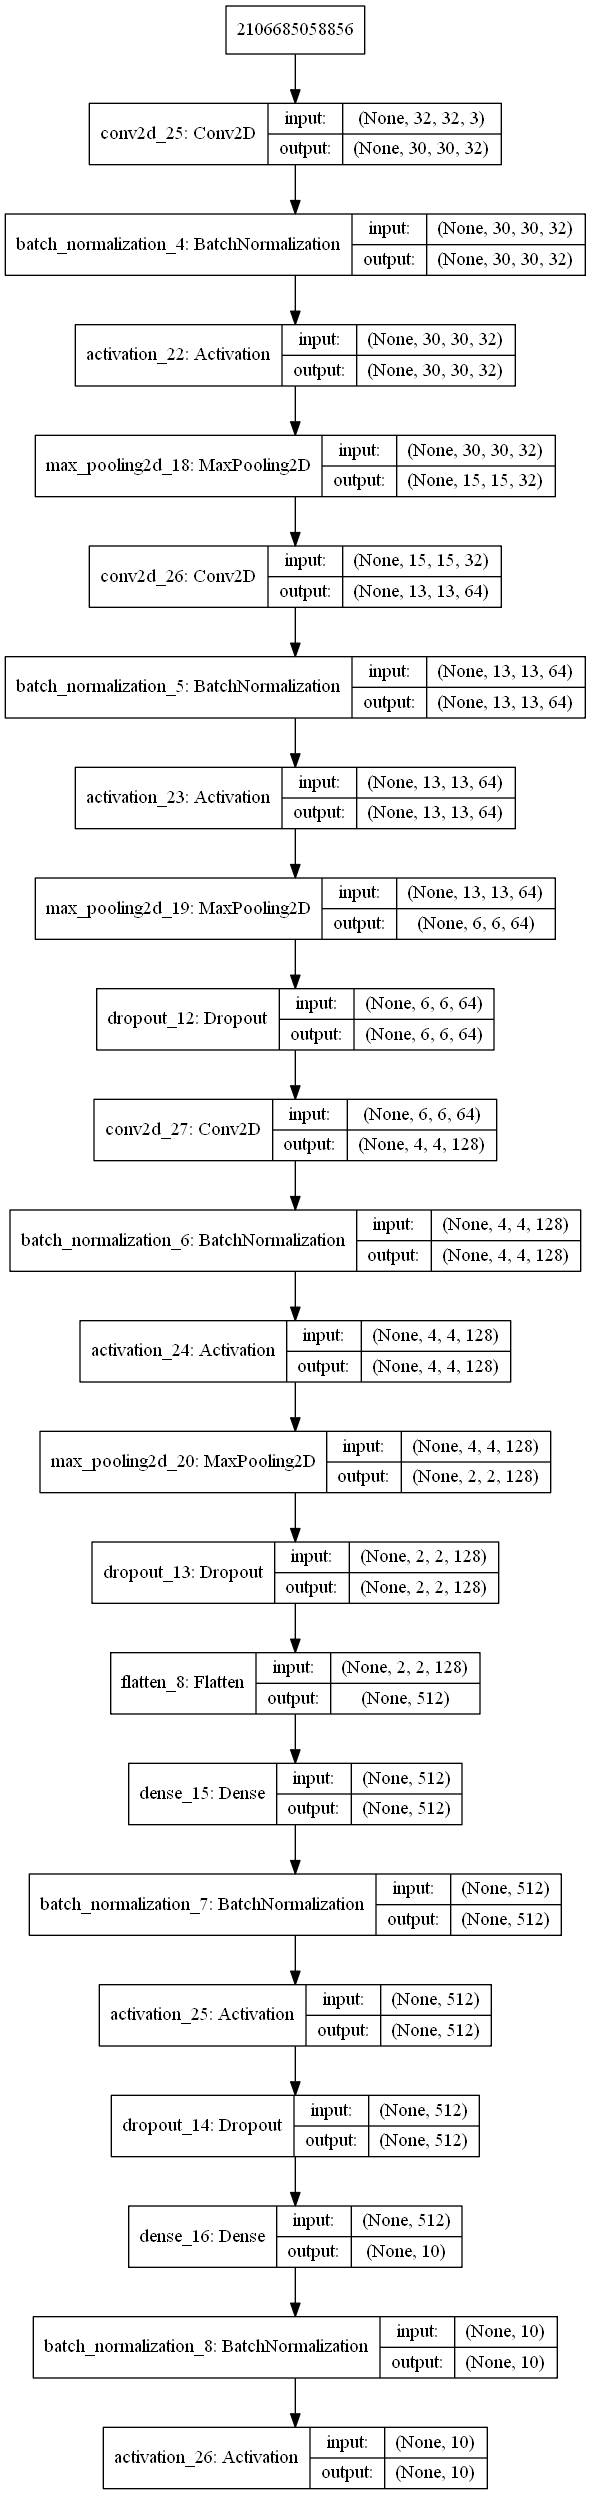

# STEP 8.
## New Architecture Performance Evaluation:

Train and evaluate your architecture on the CIFAR10 dataset on at least 200 epochs.  Make sure data_augmentation = False.   Examine the training and validation curves during training and include them in your document.  What can you tell about these models from these curves.  Do they have enough capacity?  Were they trained long enough?  Report standard classification metrics including loss and accuracy as well as a confusion matrix.  Compare your performance to both the instructor-provided models and the state-of-the-art performers. Compare your trained model to the instructor-provided model(s) and the model you implemented from the literature (be sure to use the data augmenter to train each model the same way to have a fair comparison).  Document the results of the comparison in your report.

insert your response here... note that you will probably need to save & reload performance information recorded during training/test of these networks in order to recreate figures & provide performance info here.  Feel free to use code cells to do this as necessary:  

In [17]:
# %%time
# runCode(model2run=3, epochs = 200, data_augmentation = False, cutout=True, patience=30, verbose=0, 
#         batch_size = 32)

####  The training accuracy increases overtime, until it nearly reaches 85%, but the validation accuracy stalls at around 75-80% as is shown in the figures above. The model starts over fitting which is unsurprising given the small amount of training samples and the simplicity of the architecture. This model has a validation loss of 0.649 and a validation accuracy of 77.85%. Its 0.9% more accurate then the Deep model provided with a quarter of the parameters as shown in the table below. 



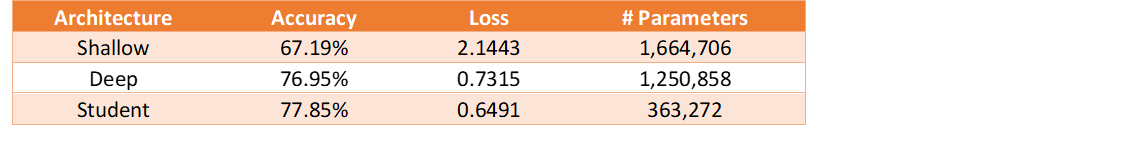

# Run Performance Evaluation 

Starting script.
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Loaded trained model from C:\Users\Brett\Documents\AFIT\courses\CSCE 823\CSCE 823 2022\06-Assignments\HW3\student_example_solution_Rosiario\saved_models\keras_cifar10_Rosario_final_model.h5 
10000 test samples
y_test shape:  (10000, 10)
313/313 [==============================] - 1s 3ms/step - loss: 0.6491 - accuracy: 0.7785

------------------
Model Accuracy = 0.78

model metrics:  [0.6490830183029175, 0.7785000205039978]
prediction shape:  (10000, 10)
actual class ID shape:  (10000,)
predicted class ID shape:  (10000,)
labels names:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[[820  15  15  29  16   8  27   9  55   6]
 [ 12 894   1  13   1   5  24   1  14  35]
 [ 58   3 591  63  51  70 137  15   9   3]
 [ 16   5  24 699  28 114 100  10   3   1]
 [ 10   0  25  56 742  29 119  13   5   1]
 [  7   0  17 171  28 696  62  17   1   1]
 [  3   2   2  27   

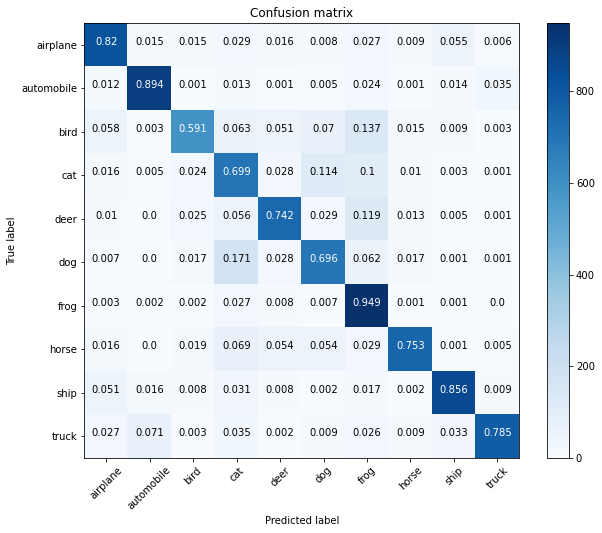

Actual Label = cat vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = ship vs. Predicted Label = ship
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = frog vs. Predicted Label = frog
Actual Label = frog vs. Predicted Label = frog
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = frog vs. Predicted Label = frog
Actual Label = cat vs. Predicted Label = cat
Actual Label = automobile vs. Predicted Label = automobile
Actual Label = airplane vs. Predicted Label = airplane
Actual Label = truck vs. Predicted Label = truck
Actual Label = dog vs. Predicted Label = cat
Actual Label = horse vs. Predicted Label = horse
Actual Label = truck vs. Predicted Label = truck
Actual Label = ship vs. Predicted Label = ship
Actual Label = dog vs. Predicted Label = dog
Actual Label = horse vs. Predicted Label = cat
Actual Label = ship vs. Predicted Label = ship
Actual Label = frog vs. Predicted Label = frog
Actual Label = horse v

In [18]:
# Set model2run to run the performance evaluation code
#1 - Shallow model
#2 - Deep model
#3 - Student model
#4 - Student model with cutout
runCode(model2run=3)

# Additional effects to improve our model

#### We experimented using data augmentation on the model but there wasn't much performance improvement. This architecture is to simple to learn the complexities of the data in a generalizable manner. The model using augmentation only improved by 2.93%. The accuracy plot are shown below.

In [19]:
# %%time
# runCode(model2run=3, epochs = 200, data_augmentation = True, cutout=True, patience=30, verbose=0, 
#         batch_size = 32)